In [2]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [3]:
df = pd.read_csv("dataset.csv")  

In [4]:
window_size = 200  # number of samples per window (~2–4 seconds depending on frequency)
step_size = 100    # 50% overlap

X = []
y = []

for activity in df['activity'].unique():
    df_act = df[df['activity'] == activity]
    signals = df_act[['x-axis','y-axis','z-axis']].values
    
    for start in range(0, len(signals) - window_size, step_size):
        end = start + window_size
        X.append(signals[start:end])  # shape: (window_size, 3)
        y.append(activity)
        
X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # (num_windows, window_size, 3)
print("y shape:", y.shape)


X shape: (10726, 200, 3)
y shape: (10726,)


In [5]:
scaler = StandardScaler()
X_reshaped = X.reshape(-1, 3)
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape)

In [6]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)
num_classes = y_categorical.shape[1]

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, 3)),
    BatchNormalization(),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 198, 64)           640       
                                                                 
 batch_normalization (BatchN  (None, 198, 64)          256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 98, 64)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           2

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.3, random_state=42, stratify=y_encoded)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64
)

Epoch 1/20
118/118 [==============================] - 7s 47ms/step - loss: 0.7306 - accuracy: 0.7725 - val_loss: 14.9407 - val_accuracy: 0.0823
Epoch 2/20
118/118 [==============================] - 5s 45ms/step - loss: 0.3360 - accuracy: 0.8752 - val_loss: 17.1272 - val_accuracy: 0.1914
Epoch 3/20
118/118 [==============================] - 5s 45ms/step - loss: 0.2340 - accuracy: 0.9144 - val_loss: 7.6283 - val_accuracy: 0.4002
Epoch 4/20
118/118 [==============================] - 5s 46ms/step - loss: 0.1727 - accuracy: 0.9379 - val_loss: 1.3761 - val_accuracy: 0.7887
Epoch 5/20
118/118 [==============================] - 5s 46ms/step - loss: 0.1190 - accuracy: 0.9568 - val_loss: 0.7170 - val_accuracy: 0.8515
Epoch 6/20
118/118 [==============================] - 5s 45ms/step - loss: 0.1038 - accuracy: 0.9619 - val_loss: 0.4368 - val_accuracy: 0.8993
Epoch 7/20
118/118 [==============================] - 5s 45ms/step - loss: 0.0859 - accuracy: 0.9699 - val_loss: 0.2645 - val_accuracy: 0.92

In [9]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

101/101 [==============================] - 1s 5ms/step - loss: 0.1443 - accuracy: 0.9652
Test Accuracy: 0.9652


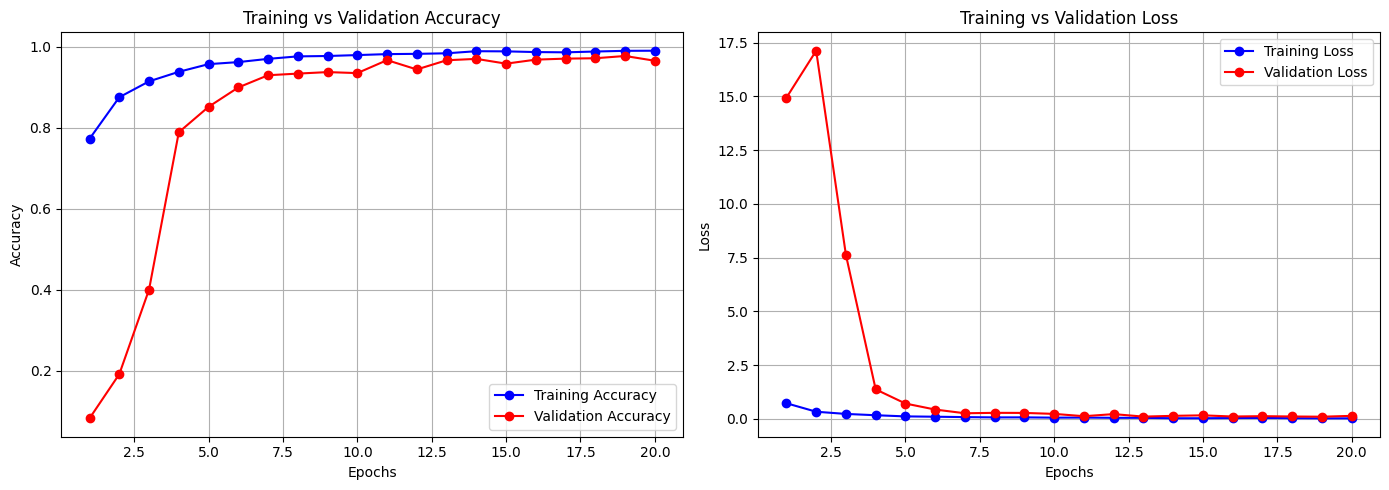

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(14,5))

# acc
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

101/101 [==============================] - 1s 4ms/step


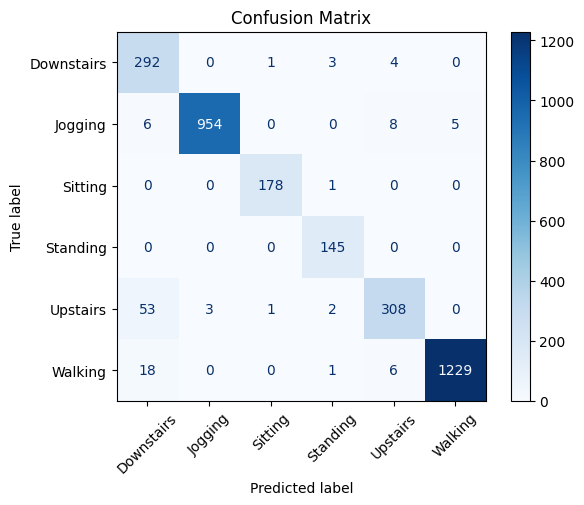

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
